# sin rnn
The purpose of this notebook is to attempt to fit an RNN to a sin series.

## imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import time

## data
The below class will be able to create a sin series, in addition to batching.

In [2]:
class TimeSeriesData():
    def __init__(self, num_points, xmin, xmax):
        #data range
        self.xmin = xmin
        self.xmax = xmax
        #data space resolution
        self.num_points = num_points
        self.resolution = (xmax - xmin) / num_points
        #defining the domain and range
        self.x_data = np.linspace(start=xmin, stop=xmax, num=num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        """
        Returns np.sin(x_series) for ANY range of inputs in x_series. This method
        will be used for comparing validity of new data.
        """
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        #grab random starting point for each batch
        rand_start = np.random.rand(batch_size, 1)
        #convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - steps * self.resolution)
        #create batch time series on x axis
        batch_ts = ts_start + np.arange(0, steps+1) * self.resolution
        #create y data for time series x axis
        y_batch = self.ret_true(batch_ts)
        #formatting for rnn
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1, steps, 1), y_batch[:,1:].reshape(-1, steps, 1)

In [3]:
ts_data = TimeSeriesData(250, 0, 10)

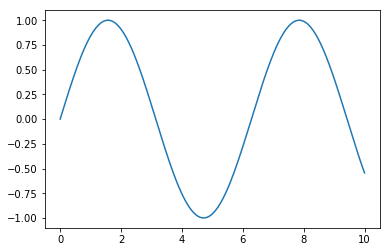

In [4]:
plt.plot(ts_data.x_data, ts_data.y_true)

## batching

In [5]:
num_time_steps = 30

In [6]:
y1, y2, ts = ts_data.next_batch(1, num_time_steps, return_batch_ts=True)

In [7]:
ts.shape

(1, 31)

In [8]:
ts

array([[ 6.91479084,  6.95479084,  6.99479084,  7.03479084,  7.07479084,
         7.11479084,  7.15479084,  7.19479084,  7.23479084,  7.27479084,
         7.31479084,  7.35479084,  7.39479084,  7.43479084,  7.47479084,
         7.51479084,  7.55479084,  7.59479084,  7.63479084,  7.67479084,
         7.71479084,  7.75479084,  7.79479084,  7.83479084,  7.87479084,
         7.91479084,  7.95479084,  7.99479084,  8.03479084,  8.07479084,
         8.11479084]])

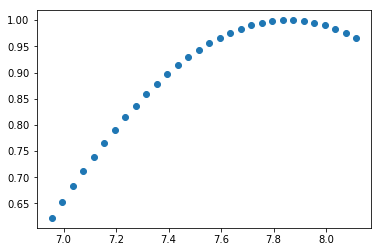

In [9]:
plt.plot(ts.flatten()[1:], y2.flatten(), "o")

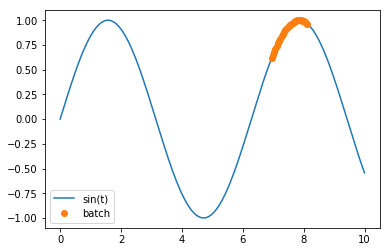

In [10]:
plt.plot(ts_data.x_data, ts_data.y_true, label="sin(t)")
plt.plot(ts.flatten()[1:], y2.flatten(), "o", label="batch")
plt.legend()

## training data

In [11]:
train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps + 1), num_time_steps + 1)
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

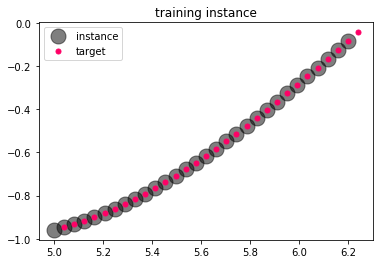

In [12]:
plt.title("training instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "ko", markersize=15, alpha=0.5, label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "o", markersize=5, alpha=1, label="target", color="#ff0066")
plt.legend()

## model creation

In [13]:
tf.reset_default_graph()

In [14]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
epochs = 2000
batch_size = 1

placeholders

In [15]:
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

rnn cell layer

In [18]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu)
#wrap output to get 1 output
cell = tf.contrib.rnn.OutputProjectionWrapper(cell=cell, output_size=num_outputs)

In [19]:
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=x, dtype=tf.float32)

loss

In [20]:
#mse
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer

In [21]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

## session

In [22]:
init = tf.global_variables_initializer()

In [23]:
#only need to use this if using gpu
#gpu_optinos = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [24]:
saver = tf.train.Saver()

In [27]:
#with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict= {
            x: x_batch,
            y: y_batch
        })
        
        if i % 100 == 0:
            mse = loss.eval(feed_dict={
                x: x_batch,
                y: y_batch
            })
            print(i, "\tMSE:", mse)
            
    #save model
    file_path = "./rnn_time_series_model_codealong{}".format(int(time.time()))
    saver.save(sess=sess, save_path=file_path)

0 	MSE: 0.279008
100 	MSE: 0.00875686
200 	MSE: 0.0168042
300 	MSE: 0.0379503
400 	MSE: 0.0222177
500 	MSE: 0.00215634
600 	MSE: 0.00281136
700 	MSE: 0.0143909
800 	MSE: 0.00111342
900 	MSE: 0.000807498
1000 	MSE: 0.0121946
1100 	MSE: 0.0088542
1200 	MSE: 0.000488632
1300 	MSE: 0.0183111
1400 	MSE: 0.00743367
1500 	MSE: 0.00470553
1600 	MSE: 0.00338224
1700 	MSE: 0.000305023
1800 	MSE: 0.015796
1900 	MSE: 0.00781735


## predict time series in future

In [32]:
#dont need to provide gpu config here for some reason
with tf.Session() as sess:
    saver.restore(sess=sess, save_path=file_path)
    x_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={
        x: x_new
    })

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_codealong1529273671


In [43]:
y_pred[0,:,0]

array([-0.35109004, -0.8237763 , -0.95935702, -0.8723129 , -0.86598158,
       -0.85007399, -0.8168577 , -0.79848343, -0.78956735, -0.74989659,
       -0.72938085, -0.70307708, -0.67475885, -0.63378465, -0.61464489,
       -0.56897628, -0.53522319, -0.49871433, -0.4689739 , -0.43594635,
       -0.39913371, -0.35738456, -0.3146438 , -0.27309376, -0.2346293 ,
       -0.19626383, -0.16248824, -0.12851238, -0.09381086, -0.05497166], dtype=float32)

In [42]:
y_pred.flatten()

array([-0.35109004, -0.8237763 , -0.95935702, -0.8723129 , -0.86598158,
       -0.85007399, -0.8168577 , -0.79848343, -0.78956735, -0.74989659,
       -0.72938085, -0.70307708, -0.67475885, -0.63378465, -0.61464489,
       -0.56897628, -0.53522319, -0.49871433, -0.4689739 , -0.43594635,
       -0.39913371, -0.35738456, -0.3146438 , -0.27309376, -0.2346293 ,
       -0.19626383, -0.16248824, -0.12851238, -0.09381086, -0.05497166], dtype=float32)

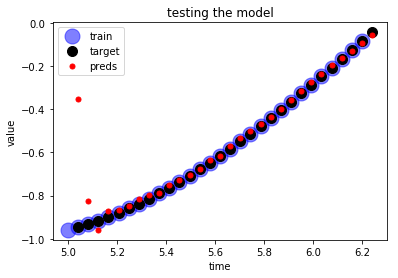

In [45]:
plt.title("testing the model")
#training
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15, alpha=0.5, label="train")
#target
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")
#prediction
plt.plot(train_inst[1:], y_pred.flatten(), "ro", markersize=5, label="preds")
#axes
plt.xlabel("time")
plt.ylabel("value")
plt.legend()